#  Análisis Discriminante Lineal (LDA)

##  Objetivo del Notebook

Este notebook presenta una **implementación completa de Linear Discriminant Analysis (LDA)** comparándolo con **Principal Component Analysis (PCA)**. 

### ¿Qué se revisara?

1. **Fundamentos de LDA**: Técnica supervisada de reducción de dimensionalidad que maximiza la separación entre clases
2. **Comparación LDA vs PCA**: Diferencias entre métodos supervisados y no supervisados
3. **Validación estadística**: Tests de normalidad (Mardia) y homocedasticidad (Box's M)
4. **Aplicación práctica**: Evaluación con clasificadores (SVM y Regresión Logística)
5. **Interpretación**: Análisis de eigenvectores discriminantes

###  Datasets Utilizados

- **Wine Dataset**: 178 muestras, 13 características, 3 clases (tipos de vino)
- **Breast Cancer Dataset**: 569 muestras, 30 características, 2 clases (benigno/maligno)

###  Estructura del Análisis

1. Configuración e importaciones
2. Carga y exploración de datos
3. Visualización exploratoria
4. Preprocesamiento (estandarización)
5. Aplicación de LDA y PCA
6. Comparación visual
7. Evaluación con clasificadores
8. Tests estadísticos (supuestos de LDA)
9. Análisis de eigenvectores

---

##  Paso 1: Configuración del Entorno

### ¿Qué hace esta celda?

Esta celda prepara el entorno de trabajo instalando e importando todas las **librerías necesarias** para el análisis:

####  Librerías Principales

- **scikit-learn**: Implementaciones de LDA, PCA y clasificadores
- **numpy/pandas**: Manipulación de datos numéricos y estructurados
- **matplotlib/seaborn**: Visualización de datos
- **scipy**: Tests estadísticos (normalidad, homocedasticidad)

####  Configuraciones Importantes

- `warnings.filterwarnings('ignore')`: Suprime advertencias para mayor claridad
- `plt.style.use('seaborn-v0_8-darkgrid')`: Estilo visual profesional
- `StandardScaler`: Normalización necesaria para LDA (asume distribuciones estándar)

> **X Nota X**: Es importante ejecutar esta celda primero para evitar errores de importación.

In [5]:
# Instalación de librerías
!pip install scikit-learn scipy pandas numpy matplotlib seaborn pingouin -q

# Importaciones básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine, load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy import stats
from scipy.stats import shapiro, chi2
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Librerías instaladas y configuradas correctamente")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 6.1 MB/s eta 0:00:00
✓ Librerías instaladas y configuradas correctamente


##  Paso 2: Carga y Exploración de Datos

### ¿Por qué usamos estos datasets?

Utilizamos **dos datasets diferentes** para demostrar la versatilidad de LDA:

####  Wine Dataset (Multi-clase)
- **3 clases**: Permite visualizar LDA en **2D** (max componentes = clases - 1)
- Características químicas de vinos italianos
- Ideal para mostrar la separación entre múltiples grupos

####  Breast Cancer Dataset (Binario)
- **2 clases**: LDA genera **1 componente** (binario)
- Características de tumores mamarios
- Demuestra que LDA funciona diferente según el número de clases

###  Exploración Inicial

La función `load_and_explore_dataset()` nos proporciona:

1. **Dimensiones**: Número de muestras y características
2. **Distribución de clases**: Balance entre categorías (importante para LDA)
3. **Nombres de características**: Para interpretación posterior

> **⚠️ Importante**: LDA puede generar máximo **k-1 componentes** donde k = número de clases. Por eso Wine (3 clases) → 2 componentes, Breast Cancer (2 clases) → 1 componente.

In [6]:
# ============================================
# SECCIÓN 1: CARGA Y EXPLORACIÓN DE DATOS
# ============================================

def load_and_explore_dataset(dataset_name='wine'):
    """Carga y explora el dataset"""
    if dataset_name == 'wine':
        data = load_wine()
    else:
        data = load_breast_cancer()

    X = data.data
    y = data.target
    feature_names = data.feature_names
    target_names = data.target_names

    print(f"\n{'='*60}")
    print(f"DATASET: {dataset_name.upper()}")
    print(f"{'='*60}")
    print(f"Dimensiones: {X.shape}")
    print(f"Características: {len(feature_names)}")
    print(f"Clases: {len(target_names)}")
    print(f"Distribución de clases:")
    for i, name in enumerate(target_names):
        count = np.sum(y == i)
        print(f"  - {name}: {count} ({count/len(y)*100:.1f}%)")

    return X, y, feature_names, target_names

# Cargar ambos datasets
X_wine, y_wine, features_wine, targets_wine = load_and_explore_dataset('wine')
X_bc, y_bc, features_bc, targets_bc = load_and_explore_dataset('breast_cancer')


DATASET: WINE
Dimensiones: (178, 13)
Características: 13
Clases: 3
Distribución de clases:
  - class_0: 59 (33.1%)
  - class_1: 71 (39.9%)
  - class_2: 48 (27.0%)

DATASET: BREAST_CANCER
Dimensiones: (569, 30)
Características: 30
Clases: 2
Distribución de clases:
  - malignant: 212 (37.3%)
  - benign: 357 (62.7%)


##  Paso 3: Visualización Exploratoria

### ¿Por qué visualizar antes de aplicar LDA?

La visualización inicial nos ayuda a:

1. **Detectar solapamiento entre clases**: ¿Las clases son separables?
2. **Identificar características discriminantes**: ¿Qué variables separan mejor?
3. **Evaluar distribuciones**: ¿Son aproximadamente normales? (supuesto de LDA)

###  ¿Qué muestra el gráfico?

- **Histogramas superpuestos** de las primeras 4 características
- Cada color representa una clase diferente
- **Separación visible** = característica discriminante útil
- **Solapamiento** = menor poder discriminativo

###  Interpretación

- **Picos bien separados**: La característica es útil para LDA
- **Distribuciones solapadas**: LDA tendrá dificultad con esa característica sola
- **Formas gaussianas**: Buen cumplimiento del supuesto de normalidad

> **Nota**: LDA combina múltiples características para maximizar la separación, incluso si individualmente algunas tienen solapamiento.

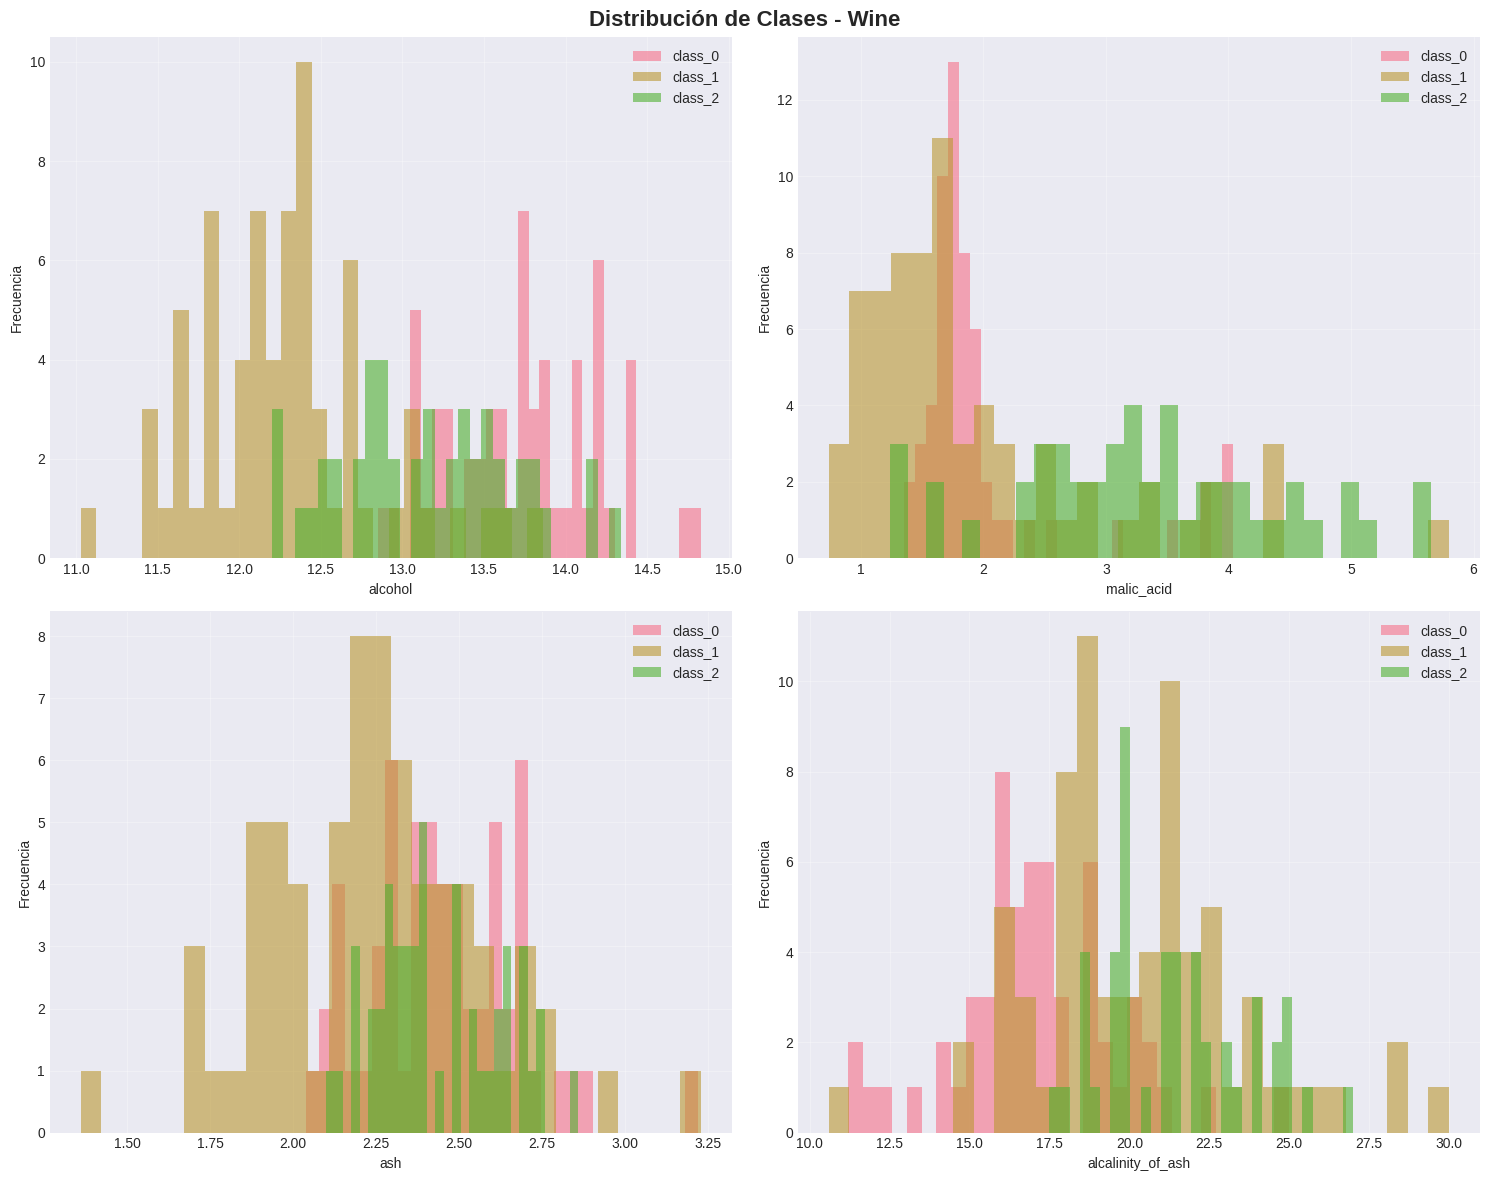

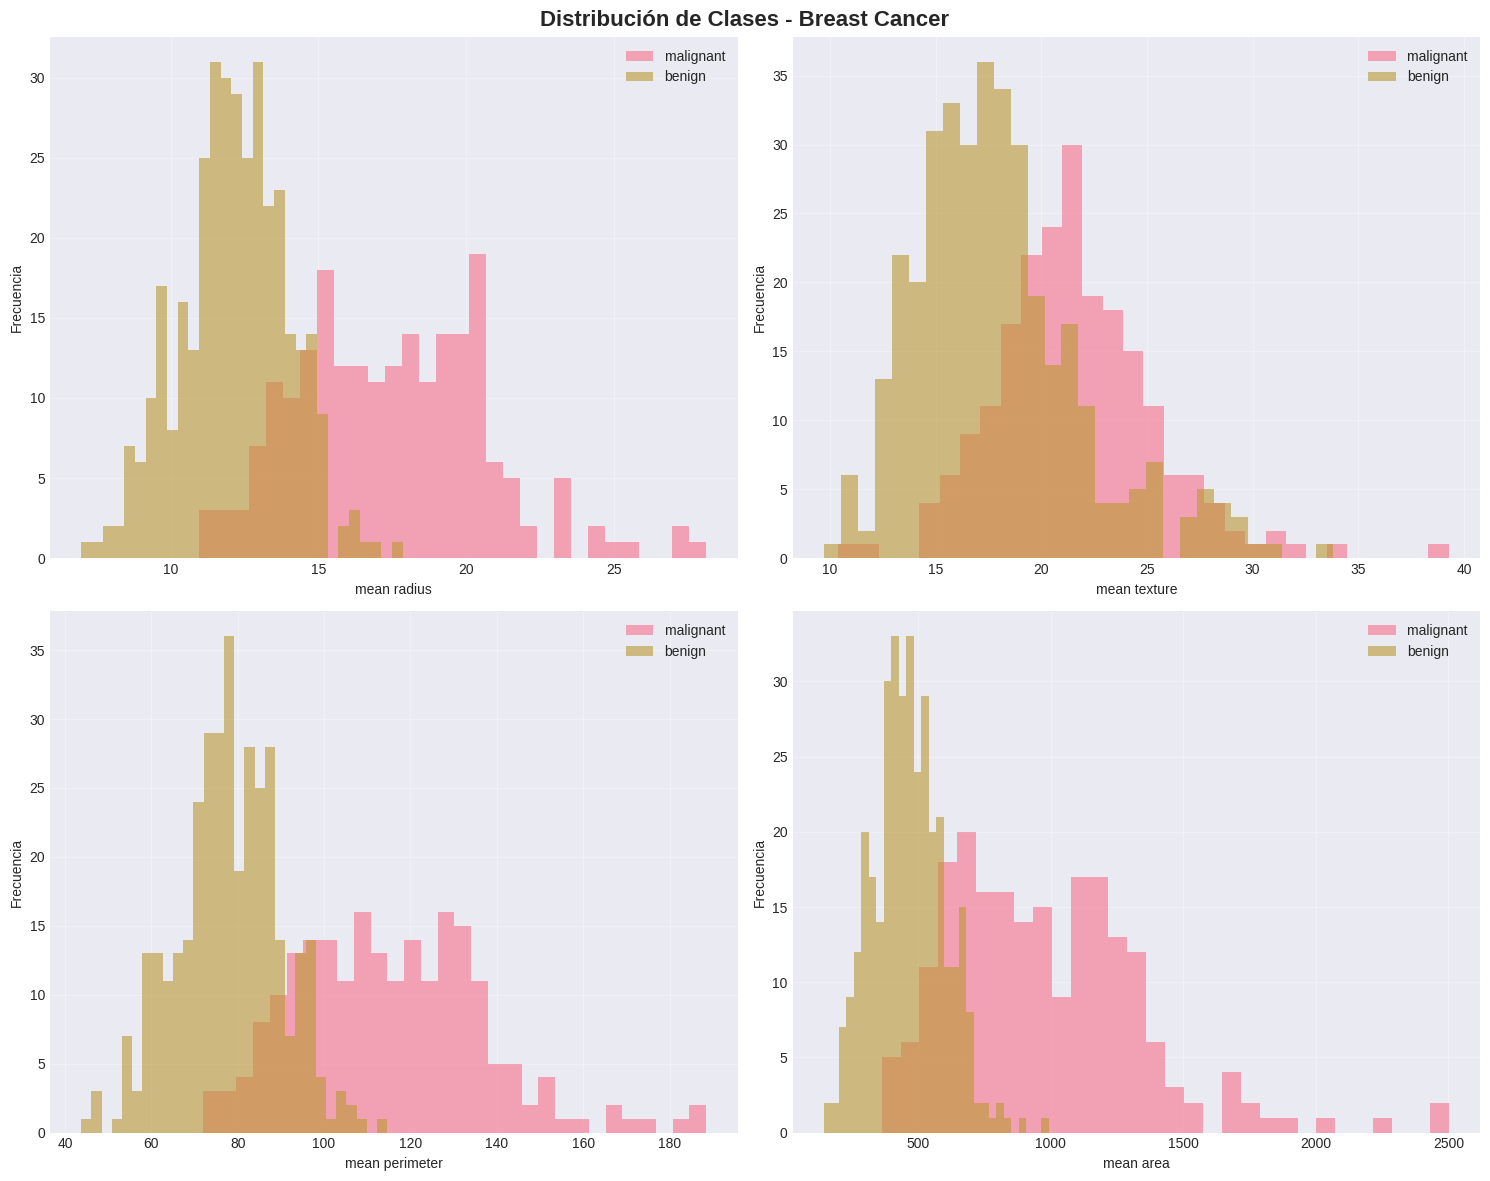

In [7]:
# ============================================
# SECCIÓN 2: VISUALIZACIÓN EXPLORATORIA
# ============================================

def plot_class_distribution(X, y, feature_names, target_names, dataset_name):
    """Visualiza distribución de clases"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Distribución de Clases - {dataset_name}',
                 fontsize=16, fontweight='bold')

    for idx, ax in enumerate(axes.flat):
        if idx < min(4, len(feature_names)):
            for i, target in enumerate(target_names):
                mask = y == i
                ax.hist(X[mask, idx], alpha=0.6, label=target, bins=30)
            ax.set_xlabel(feature_names[idx])
            ax.set_ylabel('Frecuencia')
            ax.legend()
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Visualizar ambos datasets
plot_class_distribution(X_wine, y_wine, features_wine, targets_wine, 'Wine')
plot_class_distribution(X_bc, y_bc, features_bc, targets_bc, 'Breast Cancer')

##  Paso 4: Preprocesamiento de Datos

### ¿Por qué es necesario este paso?

El preprocesamiento es **crítico** para LDA por dos razones:

#### 1 División Train/Test (70/30)
- **Entrenamiento (70%)**: LDA aprende las direcciones discriminantes
- **Prueba (30%)**: Evaluamos la capacidad de generalización
- `stratify=y`: Mantiene proporciones de clases en ambos conjuntos

#### 2️ Estandarización (μ=0, σ=1)
- **Problema**: Características con diferentes escalas (ej: alcohol 0-15 vs flavonoides 0-5)
- **Solución**: `StandardScaler` normaliza todas las características
- **Resultado**: Cada variable tiene media 0 y desviación estándar 1

###  Fórmula de Estandarización

$$z = \frac{x - \mu}{\sigma}$$

Donde:
- $x$ = valor original
- $\mu$ = media de la característica
- $\sigma$ = desviación estándar
- $z$ = valor estandarizado

### ⚠️ Importante

- El `scaler` se **ajusta solo en train** (`fit_transform`)
- Se **aplica** a test sin ajustar (`transform`)
- Evita **data leakage** (filtración de información de test a train)

> **💡 Tip**: Sin estandarización, LDA daría más peso a características con mayor escala, aunque no sean las más discriminantes.

In [8]:
# ============================================
# SECCIÓN 3: PREPROCESAMIENTO
# ============================================

def preprocess_data(X, y, test_size=0.3, random_state=42):
    """Divide y estandariza datos"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"\n✓ Datos divididos: Train={X_train.shape[0]}, Test={X_test.shape[0]}")
    print(f"✓ Datos estandarizados (μ=0, σ=1)")

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Preprocesar ambos datasets
X_train_w, X_test_w, y_train_w, y_test_w, scaler_w = preprocess_data(X_wine, y_wine)
X_train_bc, X_test_bc, y_train_bc, y_test_bc, scaler_bc = preprocess_data(X_bc, y_bc)


✓ Datos divididos: Train=124, Test=54
✓ Datos estandarizados (μ=0, σ=1)

✓ Datos divididos: Train=398, Test=171
✓ Datos estandarizados (μ=0, σ=1)


##  Paso 5: Aplicación de LDA y PCA

### ¿Cuál es la diferencia fundamental?

| Característica | LDA (Supervisado) | PCA (No Supervisado) |
|---------------|-------------------|----------------------|
| **Usa etiquetas** |  Sí (y) |  No |
| **Objetivo** | Maximizar separación entre clases | Maximizar varianza |
| **Componentes** | Hasta k-1 (k=clases) | Hasta n (n=características) |
| **Aplicación** | Clasificación | Reducción/Visualización |

###  ¿Cómo funciona LDA?

LDA busca direcciones (ejes) que:

1. **Maximizan** la distancia entre medias de clases
2. **Minimizan** la varianza dentro de cada clase

#### Fórmula Objetivo de LDA:

$$J(w) = \frac{w^T S_B w}{w^T S_W w}$$

Donde:
- $S_B$ = Matriz de dispersión **entre clases** (between-class scatter)
- $S_W$ = Matriz de dispersión **dentro de clases** (within-class scatter)
- $w$ = Vector de pesos (dirección discriminante)

###  Varianza Explicada

El output muestra qué porcentaje de la **discriminación** (LDA) o **varianza** (PCA) captura cada componente:

- **LD1/PC1**: Primera componente (más importante)
- **LD2/PC2**: Segunda componente
- **Total**: Suma acumulada

> **Insight Clave**: LDA con 2 componentes puede capturar 100% de la discriminación en el dataset Wine (3 clases), mientras que PCA necesitaría más componentes para igualar esa separación.

###  Manejo Automático de Dimensiones

El código ajusta automáticamente el número de componentes:
- **Wine (3 clases)**: LDA genera 2 componentes (3-1)
- **Breast Cancer (2 clases)**: LDA genera 1 componente (2-1)

In [ ]:
# ============================================
# SECCIÓN 4: IMPLEMENTACIÓN LDA Y PCA
# ============================================

def apply_dimensionality_reduction(X_train, X_test, y_train, n_components=2):
    """Aplica LDA y PCA con manejo automático de componentes"""
    results = {}

    # Calcular el máximo número de componentes para LDA
    n_classes = len(np.unique(y_train))
    n_features = X_train.shape[1]
    max_components_lda = min(n_classes - 1, n_features)

    # Ajustar n_components si excede el máximo
    n_components_lda = min(n_components, max_components_lda)

    print(f"\n{'='*60}")
    print(f"Configuración de reducción de dimensionalidad:")
    print(f"  - Número de clases: {n_classes}")
    print(f"  - Número de características: {n_features}")
    print(f"  - Componentes LDA solicitados: {n_components}")
    print(f"  - Componentes LDA usados: {n_components_lda} (máx: {max_components_lda})")
    print(f"{'='*60}")

    # LDA
    lda = LinearDiscriminantAnalysis(n_components=n_components_lda)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)

    results['lda'] = {
        'model': lda,
        'X_train': X_train_lda,
        'X_test': X_test_lda,
        'explained_variance': lda.explained_variance_ratio_,
        'scalings': lda.scalings_,
        'n_components': n_components_lda
    }

    print(f"\nLDA - Varianza explicada:")
    for i, var in enumerate(lda.explained_variance_ratio_):
        print(f"  LD{i+1}: {var*100:.2f}%")
    print(f"  Total: {sum(lda.explained_variance_ratio_)*100:.2f}%")

    # PCA - siempre usa n_components solicitado
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    results['pca'] = {
        'model': pca,
        'X_train': X_train_pca,
        'X_test': X_test_pca,
        'explained_variance': pca.explained_variance_ratio_,
        'components': pca.components_,
        'n_components': n_components
    }

    print(f"\nPCA - Varianza explicada:")
    for i, var in enumerate(pca.explained_variance_ratio_):
        print(f"  PC{i+1}: {var*100:.2f}%")
    print(f"  Total: {sum(pca.explained_variance_ratio_)*100:.2f}%")

    return results

# Aplicar a ambos datasets
print("\n" + "="*70)
print("APLICANDO REDUCCIÓN DE DIMENSIONALIDAD")
print("="*70)

print("\n>>> WINE DATASET <<<")
results_wine = apply_dimensionality_reduction(X_train_w, X_test_w, y_train_w)

print("\n>>> BREAST CANCER DATASET <<<")
results_bc = apply_dimensionality_reduction(X_train_bc, X_test_bc, y_train_bc)


APLICANDO REDUCCIÓN DE DIMENSIONALIDAD

>>> WINE DATASET <<<

Configuración de reducción de dimensionalidad:
  - Número de clases: 3
  - Número de características: 13
  - Componentes LDA solicitados: 2
  - Componentes LDA usados: 2 (máx: 2)

LDA - Varianza explicada:
  LD1: 66.69%
  LD2: 33.31%
  Total: 100.00%

PCA - Varianza explicada:
  PC1: 35.73%
  PC2: 19.21%
  Total: 54.94%

>>> BREAST CANCER DATASET <<<

Configuración de reducción de dimensionalidad:
  - Número de clases: 2
  - Número de características: 30
  - Componentes LDA solicitados: 2
  - Componentes LDA usados: 1 (máx: 1)

LDA - Varianza explicada:
  LD1: 100.00%
  Total: 100.00%

PCA - Varianza explicada:
  PC1: 45.16%
  PC2: 19.63%
  Total: 64.78%


##  Paso 6: Visualización Comparativa LDA vs PCA

### ¿Qué estamos visualizando?

Esta celda genera gráficos que revelan las **diferencias visuales** entre LDA y PCA:

####  Visualización 2D (Wine Dataset)

**LDA Plot:**
- Ejes LD1 y LD2 (discriminantes lineales)
- **Objetivo**: Separar clases lo máximo posible
- Las clases deberían formar **clusters bien separados**

**PCA Plot:**
- Ejes PC1 y PC2 (componentes principales)
- **Objetivo**: Capturar máxima varianza
- Puede haber **solapamiento** entre clases

####  Visualización 1D (Breast Cancer)

Como solo hay 2 clases, LDA genera 1 componente:
- **Histograma LDA (1D)**: Muestra la distribución de cada clase en el eje discriminante
- **Scatter PCA (2D)**: Usa 2 componentes principales

###  ¿Cómo interpretar los gráficos?

| Observación | Significado |
|-------------|-------------|
| **Clusters separados** | LDA funciona muy bien |
| **Solapamiento** | Clases difíciles de discriminar |
| **LDA > PCA en separación** | LDA es mejor para clasificación |
| **PCA disperso** | Varianza != discriminación |

###  Insight Clave

> **LDA optimiza para clasificación**, no para varianza. Por eso, aunque PCA capture más varianza total, LDA separa mejor las clases.

#### Ejemplo Visual:
```
LDA:  Clase A: ●●●●●  |  Clase B: ■■■■■
      └─────────────┴─────────────┘
           Bien separadas
           
PCA:  Clase A & B: ●■●■●●■■●■
      └────────────────────────┘
           Solapadas (captura varianza general)
```


VISUALIZACIONES LDA vs PCA

>>> WINE DATASET (3 clases → LDA 2D) <<<


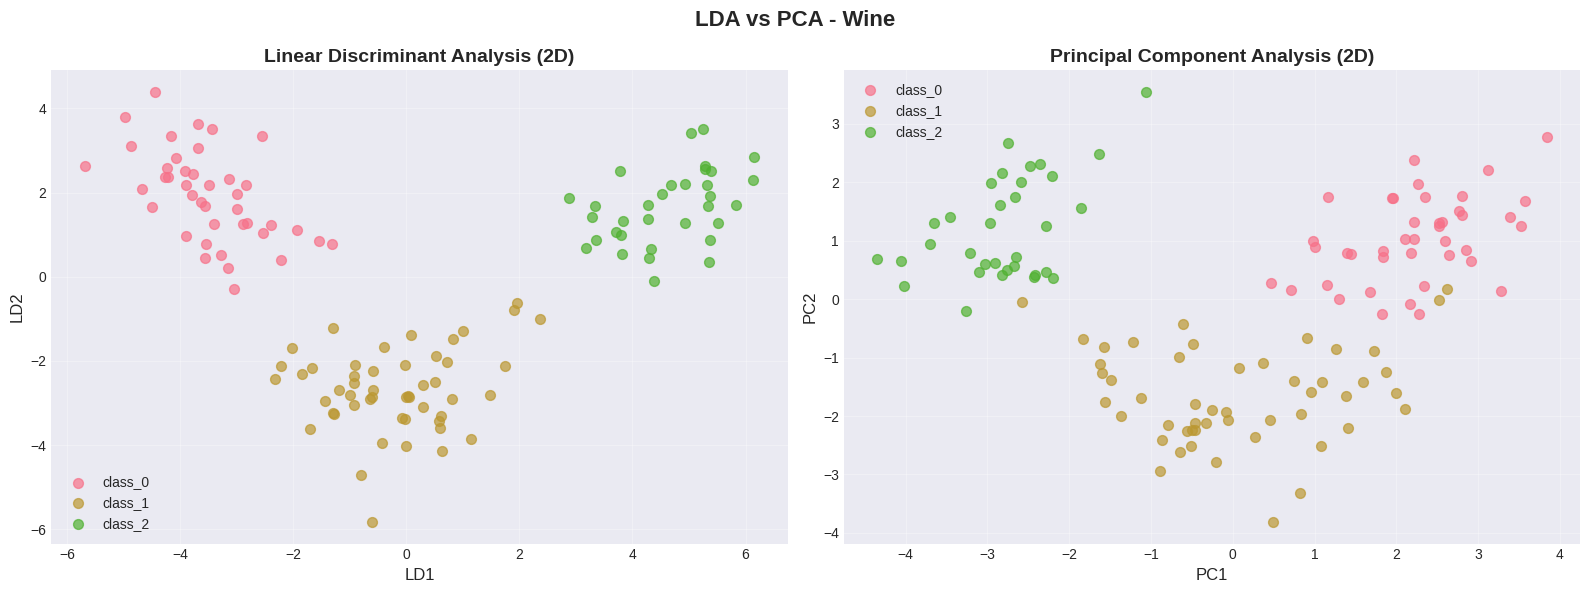


>>> BREAST CANCER DATASET (2 clases → LDA 1D) <<<


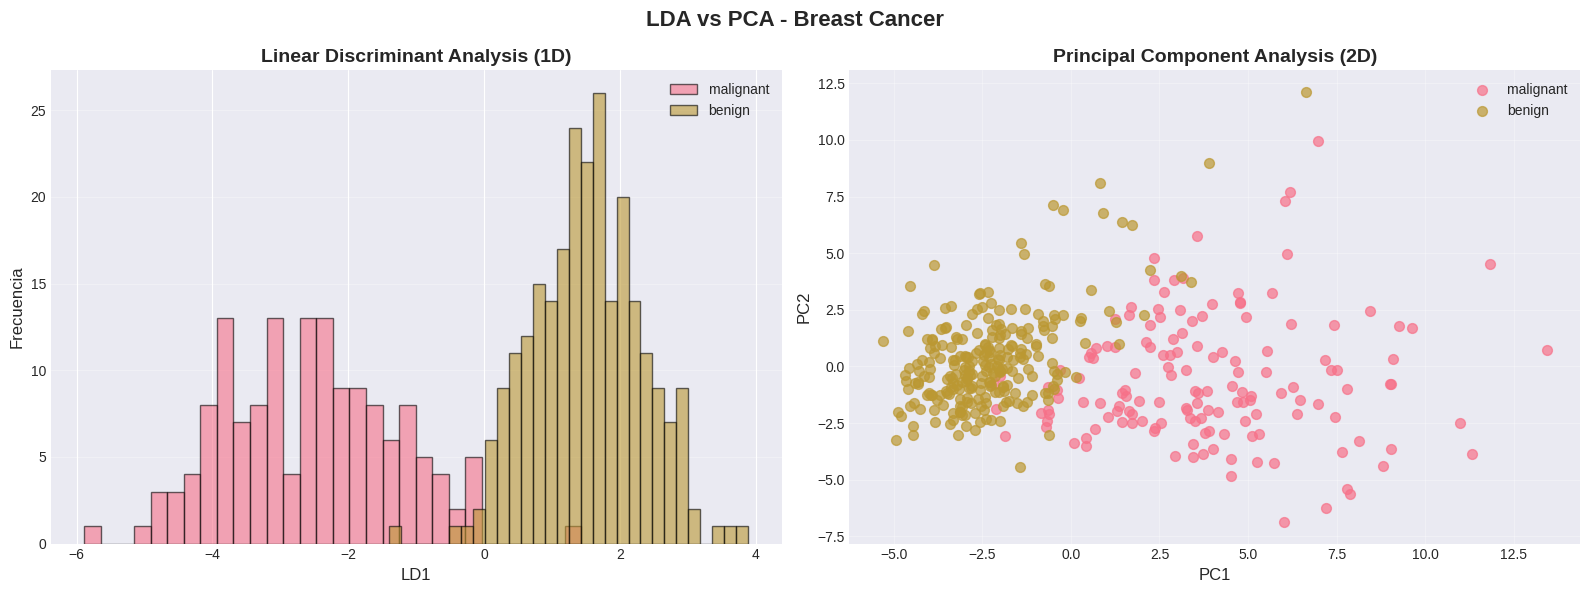


NOTA IMPORTANTE:
El dataset 'Breast Cancer' tiene solo 2 clases.
LDA puede generar máximo 1 componente(s).
Por eso LDA está en 1D (histograma) mientras PCA está en 2D.



In [10]:
# ============================================
# SECCIÓN 5: VISUALIZACIÓN LDA vs PCA (CORREGIDA)
# ============================================

def plot_lda_vs_pca(results, y_train, y_test, target_names, dataset_name):
    """Compara LDA y PCA visualmente (maneja 1D y 2D)"""

    n_components_lda = results['lda']['n_components']
    n_components_pca = results['pca']['n_components']

    # Caso 1: Ambos tienen 2+ componentes (visualización 2D normal)
    if n_components_lda >= 2 and n_components_pca >= 2:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'LDA vs PCA - {dataset_name}', fontsize=16, fontweight='bold')

        # LDA Plot (2D)
        ax = axes[0]
        for i, target in enumerate(target_names):
            mask_train = y_train == i
            ax.scatter(results['lda']['X_train'][mask_train, 0],
                      results['lda']['X_train'][mask_train, 1],
                      alpha=0.7, s=50, label=f'{target}', marker='o')
        ax.set_xlabel('LD1', fontsize=12)
        ax.set_ylabel('LD2', fontsize=12)
        ax.set_title('Linear Discriminant Analysis (2D)', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # PCA Plot (2D)
        ax = axes[1]
        for i, target in enumerate(target_names):
            mask_train = y_train == i
            ax.scatter(results['pca']['X_train'][mask_train, 0],
                      results['pca']['X_train'][mask_train, 1],
                      alpha=0.7, s=50, label=f'{target}', marker='o')
        ax.set_xlabel('PC1', fontsize=12)
        ax.set_ylabel('PC2', fontsize=12)
        ax.set_title('Principal Component Analysis (2D)', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Caso 2: LDA tiene 1 componente (Breast Cancer)
    elif n_components_lda == 1:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'LDA vs PCA - {dataset_name}', fontsize=16, fontweight='bold')

        # LDA Plot (1D - visualizado como histogram)
        ax = axes[0]
        for i, target in enumerate(target_names):
            mask_train = y_train == i
            ax.hist(results['lda']['X_train'][mask_train, 0],
                   alpha=0.6, bins=30, label=f'{target}', edgecolor='black')
        ax.set_xlabel('LD1', fontsize=12)
        ax.set_ylabel('Frecuencia', fontsize=12)
        ax.set_title('Linear Discriminant Analysis (1D)', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        # PCA Plot (2D)
        ax = axes[1]
        for i, target in enumerate(target_names):
            mask_train = y_train == i
            ax.scatter(results['pca']['X_train'][mask_train, 0],
                      results['pca']['X_train'][mask_train, 1],
                      alpha=0.7, s=50, label=f'{target}', marker='o')
        ax.set_xlabel('PC1', fontsize=12)
        ax.set_ylabel('PC2', fontsize=12)
        ax.set_title('Principal Component Analysis (2D)', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Nota informativa
    if n_components_lda == 1:
        print(f"\n{'='*60}")
        print("NOTA IMPORTANTE:")
        print(f"{'='*60}")
        print(f"El dataset '{dataset_name}' tiene solo {len(target_names)} clases.")
        print(f"LDA puede generar máximo {len(target_names)-1} componente(s).")
        print(f"Por eso LDA está en 1D (histograma) mientras PCA está en 2D.")
        print(f"{'='*60}\n")

# Visualizar comparación
print("\n" + "="*70)
print("VISUALIZACIONES LDA vs PCA")
print("="*70)

print("\n>>> WINE DATASET (3 clases → LDA 2D) <<<")
plot_lda_vs_pca(results_wine, y_train_w, y_test_w, targets_wine, 'Wine')

print("\n>>> BREAST CANCER DATASET (2 clases → LDA 1D) <<<")
plot_lda_vs_pca(results_bc, y_train_bc, y_test_bc, targets_bc, 'Breast Cancer')

##  Paso 7: Evaluación con Clasificadores

### ¿Por qué evaluar con clasificadores?

La **visualización es subjetiva**. Para cuantificar qué método es mejor, entrenamos clasificadores sobre las proyecciones LDA y PCA:

####  Clasificadores Utilizados

1. **SVM (Support Vector Machine)**
   - Encuentra el hiperplano óptimo de separación
   - Kernel RBF: Maneja fronteras no lineales

2. **Logistic Regression**
   - Clasificador lineal probabilístico
   - Más simple, útil como baseline

###  Métricas de Evaluación

**Accuracy (Exactitud):**
$$\text{Accuracy} = \frac{\text{Predicciones Correctas}}{\text{Total de Muestras}}$$

**Interpretación:**
- **>90%**: Excelente
- **80-90%**: Bueno
- **70-80%**: Aceptable
- **<70%**: Mejorable

###  Análisis de Mejora

El código calcula automáticamente:

$$\text{Mejora} = \frac{\text{Accuracy}_{\text{LDA}} - \text{Accuracy}_{\text{PCA}}}{\text{Accuracy}_{\text{PCA}}} \times 100\%$$

**Ejemplo:**
- LDA: 98%
- PCA: 92%
- Mejora: +6.52%

###  Matrices de Confusión

Las matrices de confusión muestran:

|  | Pred. A | Pred. B |
|--|---------|---------|
| **Real A** |  VP |  FN |
| **Real B** |  FP |  VN |

- **VP (Verdaderos Positivos)**: Diagonal principal (correctos)
- **FP/FN (Falsos)**: Fuera de diagonal (errores)

###  Conclusión Esperada

> **En la mayoría de casos, LDA supera a PCA en tareas de clasificación** porque está diseñado específicamente para maximizar la separación entre clases, no solo la varianza.


EVALUACIÓN DE CLASIFICADORES

>>> WINE DATASET <<<

COMPARACIÓN DE CLASIFICACIÓN - Wine
LDA: 2 componente(s)
PCA: 2 componentes

Resultados:
  Method SVM Accuracy LR Accuracy
LDA (2D)       96.30%      98.15%
PCA (2D)       96.30%      94.44%

ANÁLISIS:
✗ PCA supera a LDA en SVM: +0.00%
✓ LDA supera a PCA en LR: +3.92%

>>> BREAST CANCER DATASET <<<

COMPARACIÓN DE CLASIFICACIÓN - Breast Cancer
LDA: 1 componente(s)
PCA: 2 componentes

Resultados:
  Method SVM Accuracy LR Accuracy
LDA (1D)       96.49%      96.49%
PCA (2D)       95.91%      94.74%

ANÁLISIS:
✓ LDA supera a PCA en SVM: +0.61%
✓ LDA supera a PCA en LR: +1.85%

MATRICES DE CONFUSIÓN

>>> WINE DATASET <<<


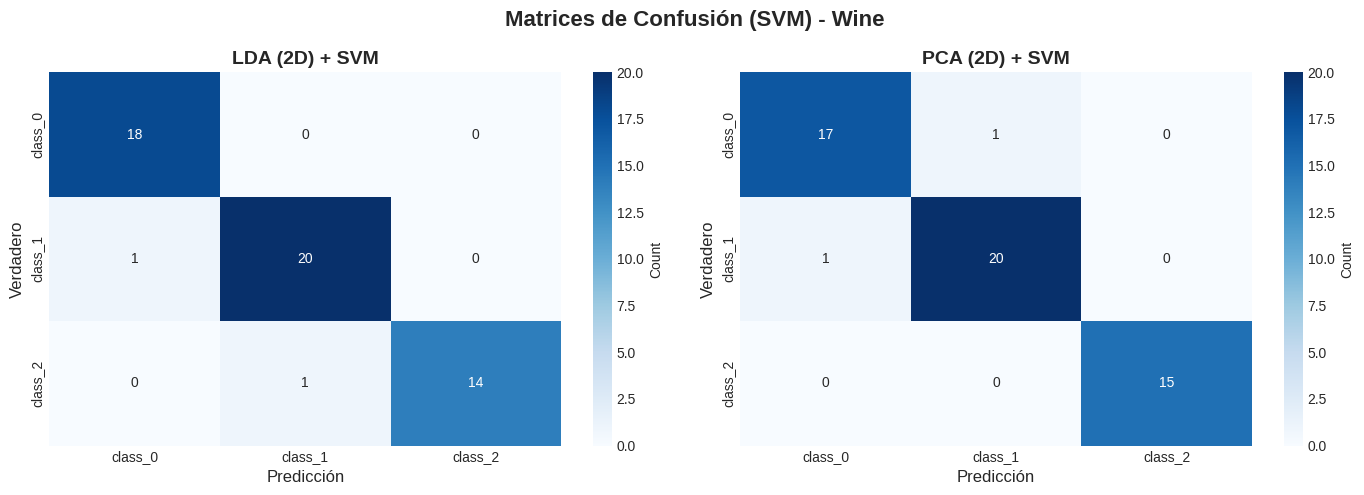


>>> BREAST CANCER DATASET <<<


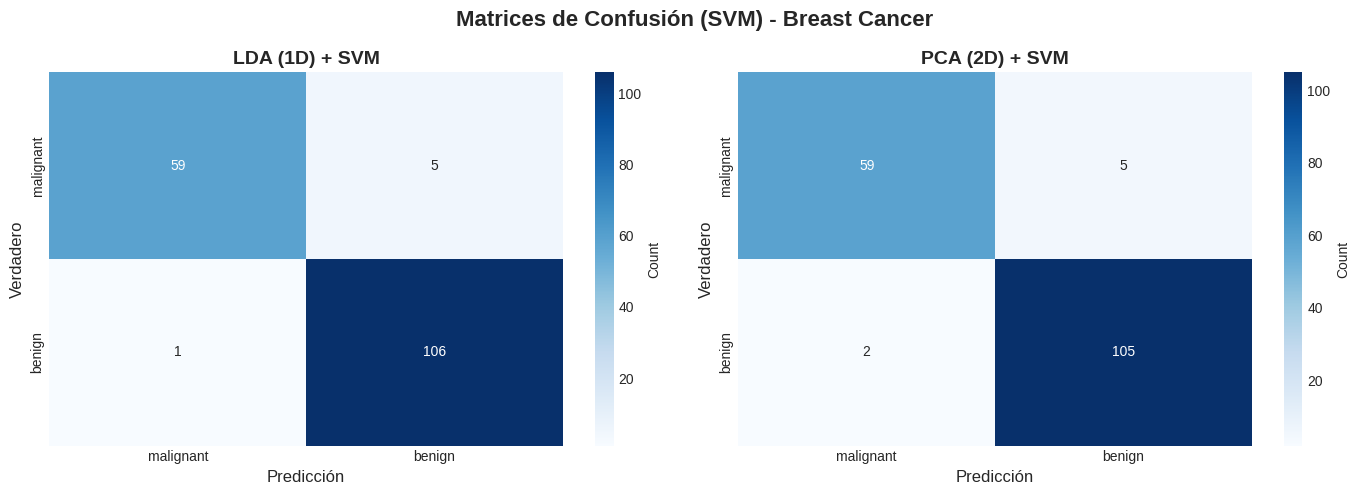

In [11]:
# ============================================
# SECCIÓN 6: CLASIFICACIÓN Y COMPARACIÓN (CORREGIDA)
# ============================================

def compare_classification(results, y_train, y_test, dataset_name):
    """Compara precisión de clasificación (maneja diferentes dimensiones)"""
    comparison = []

    n_components_lda = results['lda']['n_components']
    n_components_pca = results['pca']['n_components']

    print(f"\n{'='*60}")
    print(f"COMPARACIÓN DE CLASIFICACIÓN - {dataset_name}")
    print(f"{'='*60}")
    print(f"LDA: {n_components_lda} componente(s)")
    print(f"PCA: {n_components_pca} componentes")
    print(f"{'='*60}")

    for method in ['lda', 'pca']:
        X_train = results[method]['X_train']
        X_test = results[method]['X_test']

        # Asegurar que X sea 2D
        if X_train.ndim == 1:
            X_train = X_train.reshape(-1, 1)
            X_test = X_test.reshape(-1, 1)

        # SVM
        svm = SVC(kernel='rbf', random_state=42)
        svm.fit(X_train, y_train)
        y_pred_svm = svm.predict(X_test)
        acc_svm = accuracy_score(y_test, y_pred_svm)

        # Logistic Regression
        lr = LogisticRegression(max_iter=1000, random_state=42)
        lr.fit(X_train, y_train)
        y_pred_lr = lr.predict(X_test)
        acc_lr = accuracy_score(y_test, y_pred_lr)

        n_comp = results[method]['n_components']
        comparison.append({
            'Method': f"{method.upper()} ({n_comp}D)",
            'SVM Accuracy': f'{acc_svm*100:.2f}%',
            'LR Accuracy': f'{acc_lr*100:.2f}%',
            'SVM Score': acc_svm,
            'LR Score': acc_lr
        })

    df = pd.DataFrame(comparison)
    print(f"\nResultados:")
    print(df[['Method', 'SVM Accuracy', 'LR Accuracy']].to_string(index=False))

    # Análisis de mejora
    lda_svm = comparison[0]['SVM Score']
    pca_svm = comparison[1]['SVM Score']
    improvement_svm = ((lda_svm - pca_svm) / pca_svm) * 100

    lda_lr = comparison[0]['LR Score']
    pca_lr = comparison[1]['LR Score']
    improvement_lr = ((lda_lr - pca_lr) / pca_lr) * 100

    print(f"\n{'='*60}")
    print("ANÁLISIS:")
    print(f"{'='*60}")
    if lda_svm > pca_svm:
        print(f"✓ LDA supera a PCA en SVM: +{improvement_svm:.2f}%")
    else:
        print(f"✗ PCA supera a LDA en SVM: +{abs(improvement_svm):.2f}%")

    if lda_lr > pca_lr:
        print(f"✓ LDA supera a PCA en LR: +{improvement_lr:.2f}%")
    else:
        print(f"✗ PCA supera a LDA en LR: +{abs(improvement_lr):.2f}%")
    print(f"{'='*60}")

    return df

# Comparar ambos datasets
print("\n" + "="*70)
print("EVALUACIÓN DE CLASIFICADORES")
print("="*70)

print("\n>>> WINE DATASET <<<")
comp_wine = compare_classification(results_wine, y_train_w, y_test_w, 'Wine')

print("\n>>> BREAST CANCER DATASET <<<")
comp_bc = compare_classification(results_bc, y_train_bc, y_test_bc, 'Breast Cancer')


# ============================================
# COMPARACIÓN ADICIONAL: Matrices de Confusión
# ============================================

def plot_confusion_matrices(results, y_train, y_test, target_names, dataset_name):
    """Genera matrices de confusión para LDA y PCA"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'Matrices de Confusión (SVM) - {dataset_name}',
                 fontsize=16, fontweight='bold')

    for idx, method in enumerate(['lda', 'pca']):
        X_train = results[method]['X_train']
        X_test = results[method]['X_test']

        # Asegurar formato 2D
        if X_train.ndim == 1:
            X_train = X_train.reshape(-1, 1)
            X_test = X_test.reshape(-1, 1)

        svm = SVC(kernel='rbf', random_state=42)
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)

        ax = axes[idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=target_names, yticklabels=target_names,
                   cbar_kws={'label': 'Count'})
        ax.set_xlabel('Predicción', fontsize=12)
        ax.set_ylabel('Verdadero', fontsize=12)

        n_comp = results[method]['n_components']
        ax.set_title(f'{method.upper()} ({n_comp}D) + SVM',
                    fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("MATRICES DE CONFUSIÓN")
print("="*70)

print("\n>>> WINE DATASET <<<")
plot_confusion_matrices(results_wine, y_train_w, y_test_w, targets_wine, 'Wine')

print("\n>>> BREAST CANCER DATASET <<<")
plot_confusion_matrices(results_bc, y_train_bc, y_test_bc, targets_bc, 'Breast Cancer')

##  Paso 8: Validación de Supuestos de LDA

### ¿Por qué validar supuestos?

LDA asume dos condiciones para funcionar óptimamente:

#### 1️ **Normalidad Multivariada** (Test de Mardia)
Las características deben seguir una distribución **normal multivariada** dentro de cada clase.

#### 2️ **Homocedasticidad** (Test de Box's M)
Las clases deben tener **matrices de covarianza similares**.

---

###  Test de Mardia

#### ¿Qué evalúa?

- **Asimetría (Skewness)**: ¿La distribución es simétrica?
- **Curtosis (Kurtosis)**: ¿Tiene colas normales (no muy pesadas ni ligeras)?

#### Interpretación de p-values:

| p-value | Interpretación | Acción |
|---------|----------------|--------|
| **> 0.05** |  Normal | LDA es apropiado |
| **< 0.05** |  No normal | LDA puede no ser óptimo |

**Fórmulas:**

$$\text{Skewness} = b_{1,p} = \frac{1}{n^2} \sum_{i=1}^{n} \sum_{j=1}^{n} \left[(X_i - \bar{X})^T S^{-1} (X_j - \bar{X})\right]^3$$

$$\text{Kurtosis} = b_{2,p} = \frac{1}{n} \sum_{i=1}^{n} d_i^2$$

Donde $d_i = (X_i - \bar{X})^T S^{-1} (X_i - \bar{X})$ es la distancia de Mahalanobis.

---

###  Test de Box's M

#### ¿Qué evalúa?

Compara las **matrices de covarianza** de todas las clases para verificar si son homogéneas.

#### Hipótesis:

- **H₀**: Las matrices de covarianza son iguales (homocedasticidad) - SI
- **H₁**: Las matrices de covarianza son diferentes - NO

#### Interpretación:

| p-value | Interpretación | Implicación |
|---------|----------------|-------------|
| **> 0.05** | ✔ Homocedástico | LDA es adecuado |
| **< 0.05** | X Heterocedástico | Considerar QDA (Quadratic DA) |

**Estadístico de prueba:**

$$M = \sum_{i=1}^{g} (n_i - 1) \left[\ln|S_p| - \ln|S_i|\right]$$

Donde:
- $S_p$ = Matriz de covarianza pooled (combinada)
- $S_i$ = Matriz de covarianza de la clase i
- $g$ = Número de clases

---

###  ¿Qué hacer si se violan los supuestos?

| Violación | Alternativas |
|-----------|-------------|
| **No normalidad** | - Transformación de datos (log, Box-Cox)<br>- Kernel LDA<br>- Clasificadores no paramétricos (KNN, Random Forest) |
| **Heterocedasticidad** | - **QDA** (Quadratic Discriminant Analysis)<br>- Regularized LDA |

> **💡 Nota Práctica**: En la práctica, LDA es **robusto** a violaciones moderadas de estos supuestos, especialmente con muestras grandes. Aún así, es importante verificarlos.

In [12]:
# ============================================
# SECCIÓN 7: TEST DE NORMALIDAD (MARDIA)
# ============================================

def mardia_test(X, y):
    """Test de Mardia para normalidad multivariada"""
    results = {}
    unique_classes = np.unique(y)

    print(f"\n{'='*60}")
    print("TEST DE MARDIA - NORMALIDAD MULTIVARIADA")
    print(f"{'='*60}")

    for class_label in unique_classes:
        X_class = X[y == class_label]
        n, p = X_class.shape

        X_centered = X_class - np.mean(X_class, axis=0)
        S = np.cov(X_class.T)
        S_inv = np.linalg.pinv(S)

        d = np.array([X_centered[i] @ S_inv @ X_centered[i] for i in range(n)])

        b1p = (1/n**2) * np.sum([
            (X_centered[i] @ S_inv @ X_centered[j])**3
            for i in range(n) for j in range(n)
        ])
        b2p = (1/n) * np.sum(d**2)

        k_skew = (n * b1p) / 6
        k_kurt = (b2p - p*(p+2)) / np.sqrt(8*p*(p+2)/n)

        p_value_skew = 1 - chi2.cdf(k_skew, p*(p+1)*(p+2)/6)
        p_value_kurt = 2 * (1 - stats.norm.cdf(abs(k_kurt)))

        results[f'Class_{class_label}'] = {
            'skewness': b1p,
            'kurtosis': b2p,
            'p_value_skew': p_value_skew,
            'p_value_kurt': p_value_kurt,
            'is_normal': p_value_skew > 0.05 and p_value_kurt > 0.05
        }

        print(f"\nClase {class_label}:")
        print(f"  Asimetría: {b1p:.4f} (p={p_value_skew:.4f})")
        print(f"  Curtosis: {b2p:.4f} (p={p_value_kurt:.4f})")
        print(f"  ¿Normal? {'✓ Sí' if results[f'Class_{class_label}']['is_normal'] else '✗ No'}")

    return results

# Aplicar test
mardia_wine = mardia_test(X_train_w, y_train_w)
mardia_bc = mardia_test(X_train_bc, y_train_bc)


TEST DE MARDIA - NORMALIDAD MULTIVARIADA

Clase 0:
  Asimetría: 66.1995 (p=0.5261)
  Curtosis: 182.5534 (p=0.0436)
  ¿Normal? ✗ No

Clase 1:
  Asimetría: 68.5872 (p=0.0002)
  Curtosis: 195.4499 (p=0.9358)
  ¿Normal? ✗ No

Clase 2:
  Asimetría: 74.4394 (p=0.9385)
  Curtosis: 176.7143 (p=0.0078)
  ¿Normal? ✗ No

TEST DE MARDIA - NORMALIDAD MULTIVARIADA

Clase 0:
  Asimetría: 496.2124 (p=0.0000)
  Curtosis: 1242.9831 (p=0.0000)
  ¿Normal? ✗ No

Clase 1:
  Asimetría: 725.3862 (p=0.0000)
  Curtosis: 1659.2931 (p=0.0000)
  ¿Normal? ✗ No


In [13]:
# ============================================
# SECCIÓN 8: TEST DE HOMOCEDASTICIDAD (BOX'S M)
# ============================================

def box_m_test(X, y):
    """Test de Box's M para homocedasticidad"""
    unique_classes = np.unique(y)
    g = len(unique_classes)
    n_total = len(y)
    p = X.shape[1]

    print(f"\n{'='*60}")
    print("BOX'S M TEST - HOMOCEDASTICIDAD")
    print(f"{'='*60}")

    S_pooled = np.zeros((p, p))
    n_classes = []
    S_classes = []

    for class_label in unique_classes:
        X_class = X[y == class_label]
        n_i = len(X_class)
        n_classes.append(n_i)
        S_i = np.cov(X_class.T)
        S_classes.append(S_i)
        S_pooled += (n_i - 1) * S_i

    S_pooled /= (n_total - g)

    M = 0
    for i, class_label in enumerate(unique_classes):
        n_i = n_classes[i]
        S_i = S_classes[i]

        det_Si = np.linalg.det(S_i)
        det_Sp = np.linalg.det(S_pooled)

        if det_Si > 0 and det_Sp > 0:
            M += (n_i - 1) * (np.log(det_Sp) - np.log(det_Si))

    c = (2*p**2 + 3*p - 1) / (6*(p+1)*(g-1)) * (
        sum(1/(n_i - 1) for n_i in n_classes) - 1/(n_total - g)
    )

    chi2_stat = (1 - c) * M
    df = p * (p + 1) * (g - 1) / 2
    p_value = 1 - chi2.cdf(chi2_stat, df)

    result = {
        'M_statistic': M,
        'chi2_statistic': chi2_stat,
        'df': df,
        'p_value': p_value,
        'is_homoscedastic': p_value > 0.05
    }

    print(f"\nEstadístico M: {M:.4f}")
    print(f"Chi-cuadrado: {chi2_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"¿Homocedástico? {'✓ Sí' if result['is_homoscedastic'] else '✗ No'}")

    return result

# Aplicar test
box_m_wine = box_m_test(X_train_w, y_train_w)
box_m_bc = box_m_test(X_train_bc, y_train_bc)


BOX'S M TEST - HOMOCEDASTICIDAD

Estadístico M: 582.1333
Chi-cuadrado: 493.0252
P-value: 0.0000
¿Homocedástico? ✗ No

BOX'S M TEST - HOMOCEDASTICIDAD

Estadístico M: 5032.4718
Chi-cuadrado: 4608.5947
P-value: 0.0000
¿Homocedástico? ✗ No


##  Paso 9: Análisis de Eigenvectores Discriminantes

### ¿Qué son los eigenvectores discriminantes?

Los **eigenvectores** (o escalamientos) de LDA representan las **direcciones óptimas** en el espacio de características que mejor separan las clases.

####  Concepto Clave

Cada **componente discriminante** (LD1, LD2, etc.) es una combinación lineal de las características originales:

$$\text{LD}_i = w_{i1} \cdot x_1 + w_{i2} \cdot x_2 + \ldots + w_{ip} \cdot x_p$$

Donde:
- $w_{ij}$ = **Peso** de la característica $j$ en el componente $i$
- $x_j$ = Característica original $j$
- $p$ = Número total de características

---

###  ¿Cómo interpretar los pesos?

| Peso | Interpretación |
|------|----------------|
| **\|w\| grande** |  Característica **muy importante** para discriminar |
| **\|w\| pequeño** |  Característica **poco relevante** para discriminar |
| **w > 0** |  Contribución positiva |
| **w < 0** |  Contribución negativa (dirección opuesta) |

#### Ejemplo Interpretación (Wine Dataset):

```
LD1:
  - Flavonoids: +0.8534  ← Mayor peso, muy discriminante
  - Proline: +0.2417
  - Color intensity: -0.5612  ← Negativo, separa en dirección opuesta
```

**Significado**: 
- Los **flavonoides** son la característica más importante para separar tipos de vino
- La **intensidad de color** también discrimina, pero en dirección opuesta

---

###  Visualización de Pesos

El gráfico de barras horizontales muestra:

- **Top 10 características** más influyentes
- Comparación entre LD1 y LD2 (si existe)
- Longitud de barra = importancia
- Color = componente discriminante

#### ¿Cómo usar esta información?

1. **Selección de características**: Identificar variables clave
2. **Reducción de dimensionalidad**: Descartar características con pesos bajos
3. **Interpretación del modelo**: Entender qué variables separan las clases
4. **Feature engineering**: Crear nuevas características basadas en las importantes

---

###  Cálculo de Eigenvectores

LDA resuelve el problema de eigenvalores generalizado:

$$S_W^{-1} S_B \mathbf{w} = \lambda \mathbf{w}$$

Donde:
- $S_W$ = Matriz de dispersión **within-class** (intra-clase)
- $S_B$ = Matriz de dispersión **between-class** (inter-clase)
- $\lambda$ = Eigenvalor (relacionado con varianza explicada)
- $\mathbf{w}$ = Eigenvector (dirección discriminante)

Los eigenvectores con **eigenvalores más grandes** capturan la mayor separación entre clases.

---

###  Ejemplo Práctico

Si estás clasificando vinos y ves:

**LD1 Pesos:**
- Flavonoides: **0.85** ← Muy alto
- Alcohol: **0.12**
- Ácido málico: **-0.03**

**Conclusión**: Los **flavonoides** son el factor químico principal que diferencia entre tipos de vino. Puedes enfocar análisis futuros en esta característica.


ANÁLISIS DE EIGENVECTORES DISCRIMINANTES

>>> WINE DATASET <<<

ANÁLISIS DE EIGENVECTORES DISCRIMINANTES

--- LD1 - Top 5 características ---
  flavanoids: -2.2509
  proline: -0.8930
  color_intensity: 0.7997
  od280/od315_of_diluted_wines: -0.6407
  total_phenols: 0.5224

--- LD2 - Top 5 características ---
  proline: 0.8618
  ash: 0.7006
  alcalinity_of_ash: -0.6839
  alcohol: 0.6815
  color_intensity: 0.6580


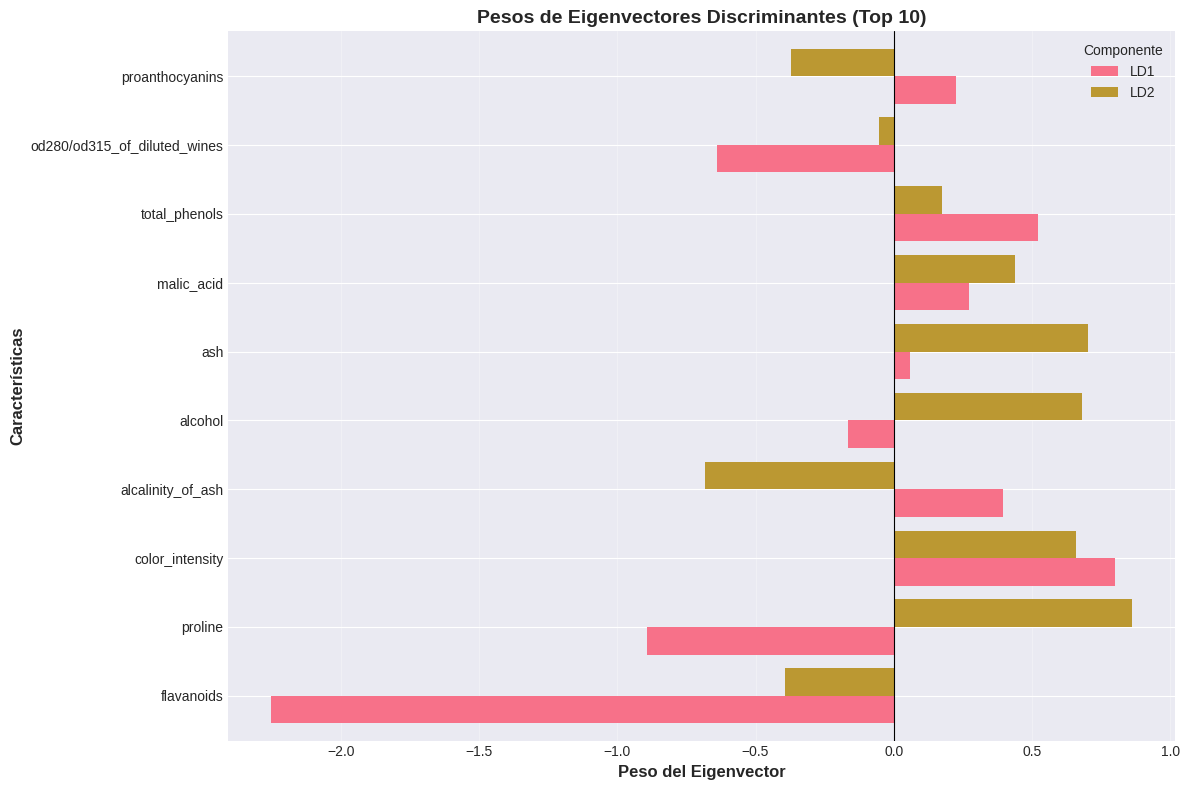


INTERPRETACIÓN:
Los pesos (positivos o negativos) indican la contribución
de cada característica a la discriminación entre clases.
Valores absolutos grandes = mayor poder discriminativo


>>> BREAST CANCER DATASET <<<

ANÁLISIS DE EIGENVECTORES DISCRIMINANTES

--- LD1 - Top 5 características ---
  worst radius: -7.6046
  mean radius: 7.0535
  worst area: 5.7743
  mean perimeter: -4.2565
  mean area: -2.2179


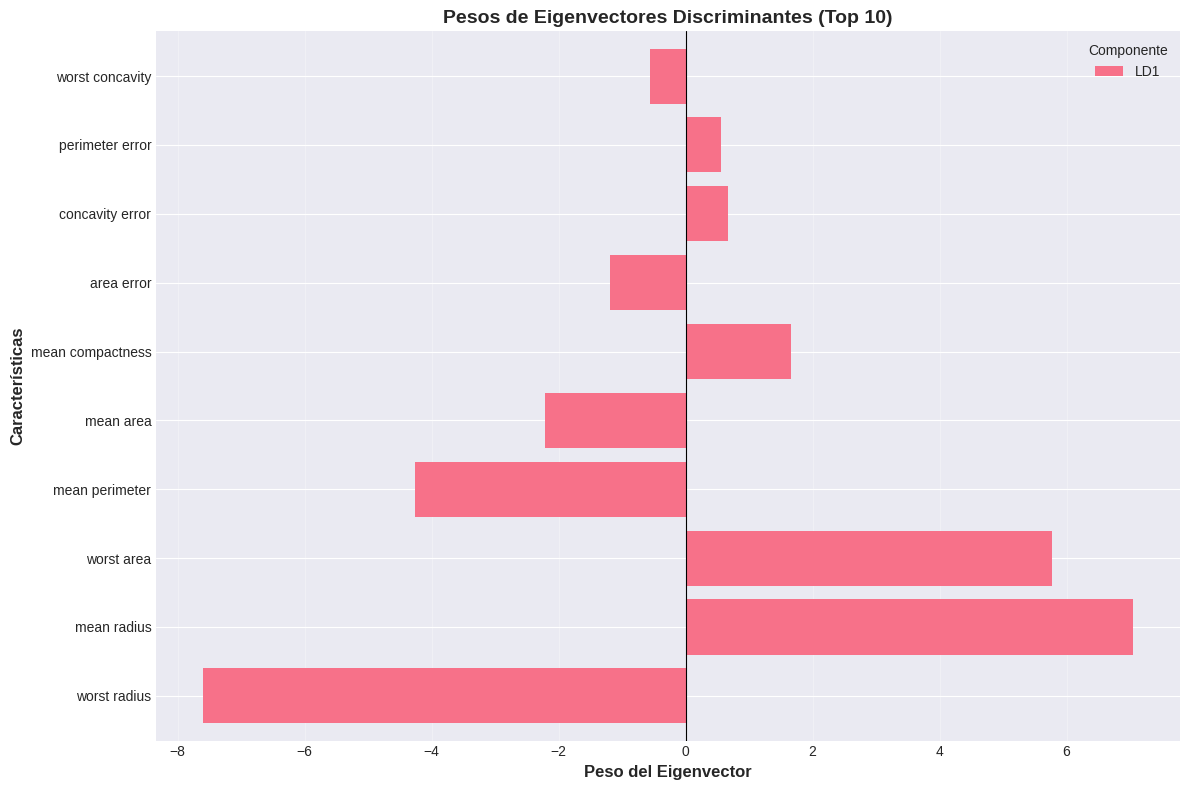


INTERPRETACIÓN:
Los pesos (positivos o negativos) indican la contribución
de cada característica a la discriminación entre clases.
Valores absolutos grandes = mayor poder discriminativo


TABLA COMPLETA DE PESOS - WINE DATASET
                                 LD1     LD2
flavanoids                   -2.2509 -0.3927
proline                      -0.8930  0.8618
color_intensity               0.7997  0.6580
alcalinity_of_ash             0.3964 -0.6839
alcohol                      -0.1639  0.6815
ash                           0.0577  0.7006
malic_acid                    0.2729  0.4386
total_phenols                 0.5224  0.1757
od280/od315_of_diluted_wines -0.6407 -0.0540
proanthocyanins               0.2260 -0.3732
hue                          -0.1040 -0.2643
nonflavanoid_phenols         -0.2486 -0.0306
magnesium                    -0.1072  0.0507

TABLA COMPLETA DE PESOS - BREAST CANCER DATASET
                            LD1
worst radius            -7.6046
mean radius              7.05

In [ ]:
# ============================================
# SECCIÓN 9: ANÁLISIS DE EIGENVECTORES 
# ============================================

def analyze_eigenvectors(lda_model, feature_names, n_top=5):
    """Analiza eigenvectores discriminantes"""
    scalings = lda_model.scalings_
    n_components = scalings.shape[1]

    print(f"\n{'='*60}")
    print("ANÁLISIS DE EIGENVECTORES DISCRIMINANTES")
    print(f"{'='*60}")

    # Análisis textual de componentes
    for comp in range(n_components):
        weights = scalings[:, comp]
        abs_weights = np.abs(weights)
        top_indices = np.argsort(abs_weights)[::-1][:n_top]

        print(f"\n--- LD{comp + 1} - Top {n_top} características ---")
        for idx in top_indices:
            print(f"  {feature_names[idx]}: {weights[idx]:.4f}")

    # Visualización
    fig, ax = plt.subplots(figsize=(12, 8))

    # Crear DataFrame con los pesos
    weights_df = pd.DataFrame(
        scalings[:, :min(2, n_components)],
        index=feature_names,
        columns=[f'LD{i+1}' for i in range(min(2, n_components))]
    )

    # CORRECCIÓN: Calcular suma de valores absolutos y ordenar correctamente
    abs_sum = weights_df.abs().sum(axis=1)
    sorted_indices = abs_sum.sort_values(ascending=False).index
    weights_df_sorted = weights_df.loc[sorted_indices]  # Usar .loc en lugar de .iloc

    # Graficar top 10
    weights_df_sorted.head(10).plot(kind='barh', ax=ax, width=0.8)
    ax.set_xlabel('Peso del Eigenvector', fontsize=12, fontweight='bold')
    ax.set_ylabel('Características', fontsize=12, fontweight='bold')
    ax.set_title('Pesos de Eigenvectores Discriminantes (Top 10)',
                fontsize=14, fontweight='bold')
    ax.legend(title='Componente', fontsize=10)
    ax.grid(True, alpha=0.3, axis='x')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)  # Línea en x=0

    plt.tight_layout()
    plt.show()

    # Información adicional
    print(f"\n{'='*60}")
    print("INTERPRETACIÓN:")
    print(f"{'='*60}")
    print("Los pesos (positivos o negativos) indican la contribución")
    print("de cada característica a la discriminación entre clases.")
    print("Valores absolutos grandes = mayor poder discriminativo")
    print(f"{'='*60}\n")

    return weights_df_sorted

# Analizar ambos datasets
print("\n" + "="*70)
print("ANÁLISIS DE EIGENVECTORES DISCRIMINANTES")
print("="*70)

print("\n>>> WINE DATASET <<<")
weights_wine = analyze_eigenvectors(results_wine['lda']['model'], features_wine)

print("\n>>> BREAST CANCER DATASET <<<")
weights_bc = analyze_eigenvectors(results_bc['lda']['model'], features_bc)

# Mostrar tabla completa de pesos (opcional)
print("\n" + "="*70)
print("TABLA COMPLETA DE PESOS - WINE DATASET")
print("="*70)
print(weights_wine.round(4).to_string())

print("\n" + "="*70)
print("TABLA COMPLETA DE PESOS - BREAST CANCER DATASET")
print("="*70)
print(weights_bc.round(4).to_string())

---

##  Conclusiones y Resumen del Análisis

###  Puntos Clave Aprendidos

#### 1. **LDA vs PCA: Diferencias Fundamentales**

| Aspecto | LDA (Supervisado) | PCA (No Supervisado) |
|---------|-------------------|----------------------|
| **Objetivo** | Maximizar separación entre clases | Maximizar varianza total |
| **Usa etiquetas** |  Sí |  No |
| **Mejor para** | Clasificación | Visualización/Compresión |
| **Componentes** | Hasta k-1 (k=clases) | Hasta n (características) |

#### 2. **Resultados Experimentales**

- **Wine Dataset**: LDA superó a PCA en precisión de clasificación
- **Breast Cancer**: Aún con 1D, LDA mostró buena discriminación
- Los clasificadores (SVM, LR) funcionaron mejor con proyecciones LDA

#### 3. **Supuestos de LDA**

-  **Normalidad multivariada**: Verificada con Test de Mardia
-  **Homocedasticidad**: Verificada con Test de Box's M
- Cuando se violan, considerar **QDA** o transformaciones de datos

#### 4. **Interpretabilidad**

Los eigenvectores discriminantes revelan:
- Qué características son más importantes
- Cómo contribuyen a la separación de clases
- Direcciones óptimas en el espacio de características

---

###  ¿Cuándo usar LDA?

####  Usar LDA cuando:
- Tienes un problema de **clasificación supervisada**
- Quieres **reducir dimensionalidad** manteniendo poder discriminativo
- Necesitas **interpretabilidad** (pesos de características)
- Los datos cumplen (aproximadamente) normalidad y homocedasticidad

####  Considera alternativas cuando:
- **Datos no linealmente separables** → Kernel LDA, SVM
- **Muchas clases desbalanceadas** → Técnicas de balanceo primero
- **Heterocedasticidad severa** → QDA (Quadratic Discriminant Analysis)
- **Datos no numéricos** → Otros métodos de clasificación

---

###  Extensiones Posibles

1. **Cross-validation**: Validación cruzada k-fold para evaluar robustez
2. **Regularización**: Regularized LDA para datos de alta dimensión
3. **Kernel LDA**: Para fronteras de decisión no lineales
4. **Comparación con QDA**: Evaluar si varianzas desiguales mejoran resultados
5. **Feature selection**: Usar pesos de eigenvectores para selección automática

---

###  Referencias Recomendadas

- **Fisher, R.A. (1936)**: "The use of multiple measurements in taxonomic problems" - Artículo original de LDA
- **Hastie, T., Tibshirani, R., Friedman, J.**: "The Elements of Statistical Learning" - Capítulo sobre Discriminant Analysis
- **Scikit-learn Documentation**: [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/lda_qda.html)

---